In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from nltk.stem import *
from sklearn.feature_extraction.text import TfidfVectorizer
from datetime import datetime, timedelta, date
%matplotlib inline
plt.style.use('ggplot')

import nltk
import string

from nltk.corpus import stopwords
pstemmer = nltk.PorterStemmer()

In [95]:
y_col = 'variety_cleaned'

In [4]:
df = pd.read_csv('data/winemag-data-130k-v2.csv')

In [35]:
df.sample(5)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
78556,78556,US,Made from grapes grown on the Olivet Lane Vine...,Orange Label,87,59.0,California,Russian River Valley,Sonoma,Virginie Boone,@vboone,Roadhouse Winery 2014 Orange Label Pinot Noir ...,Pinot Noir,Roadhouse Winery
11735,11735,US,"As in earlier vintages, this is three quarters...",NaN,89,24.0,Oregon,Walla Walla Valley (OR),Oregon Other,Paul Gregutt,@paulgwine,Watermill 2007 Cabernet Sauvignon (Walla Walla...,Cabernet Sauvignon,Watermill
66147,66147,Italy,"Aromas of acacia, nut and yellow stone fruit l...",Ronco delle Cime,88,35.0,Northeastern Italy,Collio,NaN,Kerin O’Keefe,@kerinokeefe,Venica & Venica 2015 Ronco delle Cime Friulano...,Friulano,Venica & Venica
30385,30385,Chile,It took this Concha y Toro specialty label a f...,Reserva Especial,91,22.0,Limarí Valley,NaN,NaN,Michael Schachner,@wineschach,Maycas del Limari 2010 Reserva Especial Sauvig...,Sauvignon Blanc,Maycas del Limari
36836,36836,US,"A spicy oak aroma, fresh red cherry and cranbe...",Estate,89,22.0,California,Sierra Foothills,Sierra Foothills,Jim Gordon,@gordone_cellars,Naggiar 2012 Estate Sangiovese (Sierra Foothills),Sangiovese,Naggiar


In [59]:
wine_blends =[
    (set(["merlot", "cabernet sauvignon", "cabernet franc", "petit verdot", "malbec"])
    , 'bordeaux-style red'),
    (set(["semillon", "sauvignon blanc", "muscadelle"])
    , 'bordeaux-style white'),
    (set(['grenache', 'syrah',"mourvedre","bourboulenc","cinsault","clairette blanche",
        "counoise","grenache blanc","muscardin","picardan","piquepoul blanc","roussanne",
        "terret noir","vaccarese"])
    ,"rhône-style red"),
    (set(['marsanne','roussanne','clairette','grenache blanc','bourboulenc','viognier'])
    , "rhône-style white")
   ]

repl_dir = {'petite sirah': 'syrah', 
            'shiraz': 'syrah', 
            'champagne' :'sparkling',
           }

In [61]:
def name_blends(hyph_name, wine_blends= wine_blends):
    h_names = hyph_name.split('-')
    if len(h_names) > 1:
        for grapes, name in wine_blends:
            if sum([j in grapes for j in h_names]) == len(h_names):
                return name
            else:
                return hyph_name
    else:
        return hyph_name

In [103]:
df['variety_cleaned'] = df['variety'].fillna('NA').str.lower()\
    .apply(lambda x: ' '.join([i.strip() for i in x.split() if i != 'blend']))\
    .replace(repl_dir)\
    .apply(name_blends)

In [75]:
df['variety'].unique().size

708

In [74]:
df['variety_cleaned'].unique().size

686

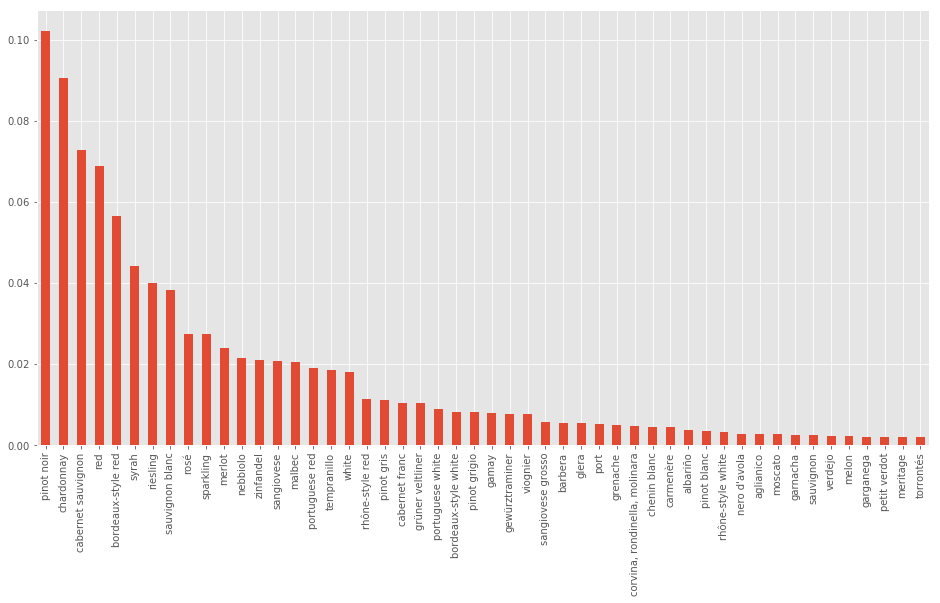

In [77]:
intr = df['variety_cleaned'].value_counts(1).head(50)
plot = intr.plot(kind='bar', figsize=(16,8));
plot.set_xticklabels(intr.index, {'rotation' : 90});

In [78]:
df.description.sample(5).values

array([ 'This gentle, ripe wine is immediately attractive. Ripe pear and peach are cut with acidity. Drink now.',
       'This blend of 60% Petite Sirah, 21% Syrah, 7% Grenache, 6% Petit Verdot, 5% Tannat and 1% Viognier is tightly wound but likely to improve with time. Opened now, it offers elderberry, black currant, pencil lead and loam on the nose, with lava rock, crème de cassis and kirsch flavors slowing emerging on the palate.',
       'Like a liquid lemon meringue pie, this Chardonnay has bright fruit flavors, lemony acidity and a creamy finish. It smells like ripe apple and pineapple, and tastes crisp but but not lean. Altogether delicious and mouthwatering, and not nearly as sweet as the pie.',
       'Enticing notions of passion fruit and peach grab the attention first, but there is almost more interest in the peppery, zesty mouth-feel. Fresh but rounded.',
       "Candied flavors of blackberries and cherries mark this dry, full-bodied Cab. It's an everyday sipper for easy fa

In [177]:
tbob = df[df['variety'].fillna('X').apply(lambda x: len(x.split('-')) < 2)]['variety'].fillna('X')\
    .str.lower()

#     .value_counts().head(30).cumsum()

In [179]:
tbob_ltd = tbob[tbob.apply(lambda x: x.split()[-1] != 'blend')]

In [183]:
tbob.shape

(117988,)

In [181]:
tbob_ltd.shape

(102135,)

In [198]:
tbob_ltd.value_counts(0).head()

pinot noir            13272
chardonnay            11753
cabernet sauvignon     9472
riesling               5189
sauvignon blanc        4967
syrah                  4142
rosé                   3564
merlot                 3102
nebbiolo               2804
zinfandel              2714
sangiovese             2707
malbec                 2652
portuguese red         2466
tempranillo            1810
pinot gris             1455
cabernet franc         1353
Name: variety, dtype: int64

In [202]:
for i in df[df['variety'] == 'Nebbiolo']['description'].sample(50).values:
    print(i)

Aromas of menthol, blue flower and dark berry lift out of the glass. The tannic palate is still primary, offering tart sour cherry and star anise while a hint of dried sage closes the firm finish.
Built like a brick house, with ripe, red aromas. This isn't light and elegant in the Italian style; it's mega ripe, with a ton of cherry, spice, kick and chocolate. Medicinal at times, peppery at others, and deep and wild throughout. Drink now through 2017.
This opens with aromas of pressed rose petal, underbrush, truffle, white pepper and leather. The already approachable palate delivers juicy black cherry, cooking spice and licorice. Drink through 2022.
Elegant and fresh, this linear wine brings together sensations of black raspberry, blue flower, licorice, white pepper and clove that are balanced with vibrant acidity and graceful tannins. Bright and delicious, it's made to be enjoyed young, so drink now.
Ugo Lequio is a winemaker who presents some of the best expressions from the Gallina C

In [135]:
for i in df[df['country'] == 'US']['variety'].unique():
    if len(i.split('-')) > 1:
        print(i)

Bordeaux-style Red Blend
Rhône-style Red Blend
G-S-M
Cabernet Sauvignon-Syrah
Syrah-Grenache
Rhône-style White Blend
Cabernet Sauvignon-Sangiovese
Syrah-Viognier
Marsanne-Roussanne
Marsanne-Viognier
Syrah-Cabernet Sauvignon
Semillon-Sauvignon Blanc
Grenache-Syrah
Sauvignon Blanc-Semillon
Bordeaux-style White Blend
Merlot-Cabernet Franc
Syrah-Petite Sirah
Gewürztraminer-Riesling
Roussanne-Viognier
Cabernet Franc-Merlot
Grenache-Carignan
Chardonnay-Semillon
Syrah-Mourvèdre
Merlot-Malbec
Mourvèdre-Syrah
Malbec-Syrah
Cabernet Sauvignon-Merlot
Merlot-Cabernet Sauvignon
Viognier-Roussanne
Cabernet Sauvignon-Cabernet Franc
Barbera-Nebbiolo
Chenin Blanc-Viognier
Grenache-Mourvèdre
Pinot-Chardonnay
Syrah-Tempranillo
Cabernet Sauvignon-Barbera
Merlot-Cabernet
Sangiovese-Cabernet Sauvignon
Viognier-Gewürztraminer
Müller-Thurgau
Chardonnay-Viognier
Semillon-Chardonnay
Tempranillo-Garnacha
Malbec-Merlot
Viognier-Chardonnay
Pinot Blanc-Pinot Noir
Sauvignon Blanc-Chenin Blanc
Pinot Gris-Gewürztramine

In [132]:
df[y_col].value_counts().head(28)

pinot noir              13272
chardonnay              11753
cabernet sauvignon       9472
red                      8946
bordeaux-style red       7344
syrah                    5748
riesling                 5189
sauvignon blanc          4967
rosé                     3564
sparkling                3549
merlot                   3102
nebbiolo                 2804
zinfandel                2714
sangiovese               2707
malbec                   2655
portuguese red           2466
tempranillo              2398
white                    2360
rhône-style red          1471
pinot gris               1455
cabernet franc           1353
grüner veltliner         1345
portuguese white         1159
bordeaux-style white     1066
pinot grigio             1052
gamay                    1025
gewürztraminer           1012
viognier                  996
Name: variety_cleaned, dtype: int64

In [84]:
df['variety_cleaned'].value_counts().head(28).index

Index(['pinot noir', 'chardonnay', 'cabernet sauvignon', 'red',
       'bordeaux-style red', 'syrah', 'riesling', 'sauvignon blanc', 'rosé',
       'sparkling', 'merlot', 'nebbiolo', 'zinfandel', 'sangiovese', 'malbec',
       'portuguese red', 'tempranillo', 'white', 'rhône-style red',
       'pinot gris', 'cabernet franc', 'grüner veltliner', 'portuguese white',
       'bordeaux-style white', 'pinot grigio', 'gamay', 'gewürztraminer',
       'viognier'],
      dtype='object')

In [97]:
# df_nona = df[df[y_col].fillna('N') != 'N']
classif_varieties = set(df['variety_cleaned'].value_counts().head(28).index)
df_nona = df[df[y_col].isin(classif_varieties)]

In [98]:
df_nona.shape

(106944, 15)

In [105]:
label_map = {val: idx for idx, val in enumerate(df_nona[y_col].unique())}

In [106]:
y = df_nona[y_col].replace(label_map).values

In [107]:
reviews = df_nona.description

In [108]:
swords = set(stopwords.words('english'))

In [109]:
ps = PorterStemmer()

In [110]:
word_vecs = reviews\
    .apply(lambda x: [re.sub("[\W]", '', i).lower().strip() for i in x.split()])\
    .apply(lambda x: [ps.stem(i) for i in x if i not in swords and len(i) > 3])

In [111]:
word_vecs.sample(10)

84717     [earthi, aroma, underbrush, use, leather, viol...
99096     [zinfandel, unlik, regular, bottl, special, se...
95311     [outstand, morellino, scansano, love, fragranc...
117211    [chardonnay, doesnt, much, riper, richer, dazz...
72062     [chocapalha, everyday, soft, fruiti, alreadi, ...
78097     [success, second, label, goldschmidt, 2009, go...
124709    [young, massiv, built, wine, need, time, devel...
69063     [wine, goe, tropic, fruit, approach, sauvignon...
71147     [champagnespeak, extra, actual, mean, somewhat...
76994     [solid, firm, wine, great, rapport, black, ber...
Name: description, dtype: object

In [112]:
back2sent = word_vecs.apply(lambda x: ' '.join(x))

In [113]:
transform = TfidfVectorizer(lowercase=False, min_df=.05)

In [114]:
tf_idf_matrix = transform.fit_transform(back2sent.values)

In [115]:
## build train_test_split
test_train = np.random.random(word_vecs.shape[0]) < .8
Xtr = tf_idf_matrix[test_train]
Xte = tf_idf_matrix[~test_train]
ytr = y[test_train]
yte = y[~test_train]

In [116]:
from sklearn.naive_bayes import GaussianNB

In [117]:
start = datetime.now()
modelgb = GaussianNB()
modelgb.fit(Xtr.toarray(), ytr)
print(modelgb.score(Xte.toarray(), yte))
print((datetime.now() - start).seconds)

0.165554570482
0


In [118]:
from sklearn.ensemble import RandomForestClassifier

In [133]:
start = datetime.now()
modelrf = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
modelrf.fit(Xtr.toarray(), ytr)
print(modelrf.score(Xte.toarray(), yte))
print((datetime.now() - start).seconds)

0.52442723158
165


In [120]:
## run this line if needed xgboost is not a part of Sklearn
## we could also use GradientBoostingClassifier, but since it does not support 
## parallel processing, and XGboost typically gives near the same performance
## we will use XGboost
#!pip install xgboost

In [121]:
import xgboost as xgb

In [122]:
start = datetime.now()
modelxg3 = xgb.XGBClassifier(max_depth=3, learning_rate=.05, n_estimators=250, n_jobs=-1)
modelxg3.fit(Xtr.toarray(), ytr)
print(modelxg3.score(Xte.toarray(), yte))
print((datetime.now() - start).seconds)

0.437590406421
343


In [123]:
start = datetime.now()
modelxg5 = xgb.XGBClassifier(max_depth=5, learning_rate=.05, n_estimators=250, n_jobs=-1)
modelxg5.fit(Xtr.toarray(), ytr)
print(modelxg5.score(Xte.toarray(), yte))
print((datetime.now() - start).seconds)

0.461201063879
572


In [124]:
start = datetime.now()
modelxg_lr1 = xgb.XGBClassifier(max_depth=5, learning_rate=.1, n_estimators=250, n_jobs=-1)
modelxg_lr1.fit(Xtr.toarray(), ytr)
print(modelxg_lr1.score(Xte.toarray(), yte))
print((datetime.now() - start).seconds)

0.477532546311
1901


In [125]:
start = datetime.now()
modelxg_t1000 = xgb.XGBClassifier(max_depth=5, learning_rate=.1, n_estimators=250, n_jobs=-1)
modelxg_t1000.fit(Xtr.toarray(), ytr)
print(modelxg_t1000.score(Xte.toarray(), yte))
print((datetime.now() - start).seconds)

0.477532546311
3174


In [ ]:
# dense_matrix = pd.DataFrame(tf_idf_matrix.todense())

# ## these may be in order of count, not the orde of the columns so this is were i messed up
# dense_matrix.columns = [v for v in transform.vocabulary_.keys()]

# dense_matrix.columns

# dense_matrix.sample(10)

# country_dm = dense_matrix.copy()

# country_dm['y'] = df['country']

In [ ]:
start = datetime.now()
#process things
print((datetime.now() - start).seconds)

In [ ]:
xgb.XGBClassifier

In [ ]:
%%timeit -n 1